In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

import numpy as np
import matplotlib 
%matplotlib notebook

import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})

import sys, glob
sys.path.append('../../')

from ase import Atoms
import MDAnalysis as mda

from cmm.xray.sgr import SGr
from cmm.xray.damping import Damping
from cmm.xray.sgr2 import RDF, SGr as SGr2, RDFSet

def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors


## Testing the sgr2.py on the simple Pt-Pt system
Checking it gives the same as debye plus the old code

<IPython.core.display.Javascript object>


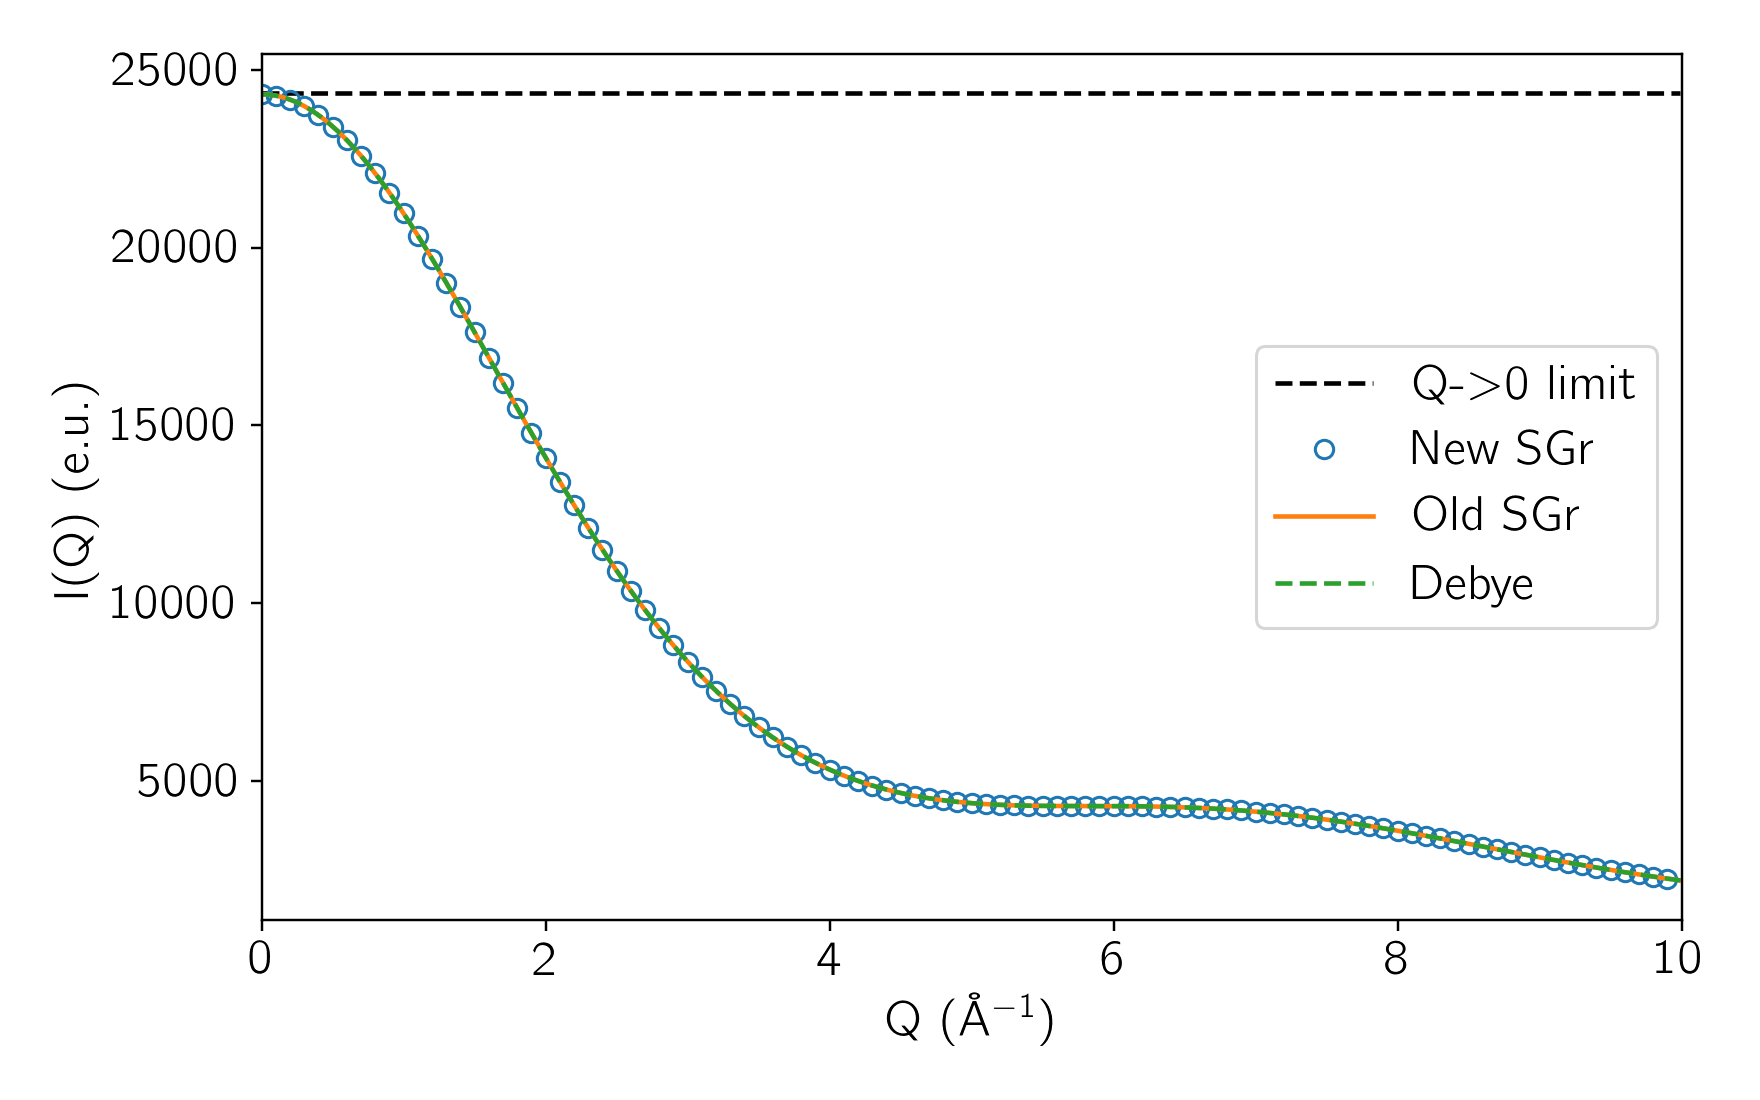

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from cmm.xray.sgr import SGr as SGr_old
from cmm.xray.sgr2 import SGr as SGr2
from cmm.xray.debye import Debye
from ase.io import read 

nel = (2*78)**2

atoms = read('../../data/test/test.xyz')
deb = Debye()
s_deb = deb.debye(atoms)

stoich = {'Pt_u':2}
Vtest = 10**3
sgr_old_test = SGr_old(Vtest, damp=None, delta=False, verbose=False, qvec=deb.qvec)
sgr_old_test.load_rdfs_fromdir('../../data/test/')
s_sgr_old_test = sgr_old_test.calculate(sgr_old_test.rdfs, stoich)


dat = np.genfromtxt('../../data/test/gPt_u-Pt_u.dat')
rdf_test = RDF(dat[:, 0], dat[:, 1], 'Pt', 'Pt', 'solute', 'solute', 2, 2)
sgr_new_test = SGr2(Vtest, qvec=deb.qvec)
s_sgr_new_test = sgr_new_test.scoh(rdf_test)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(deb.qvec, np.ones_like(s_deb) * nel, 'k--', label='Q-$>$0 limit')
ax.plot(deb.qvec[::10], s_sgr_new_test[::10], 'o', mfc='None', label='New SGr')
ax.plot(deb.qvec, s_sgr_old_test['s_u'], label='Old SGr')
ax.plot(deb.qvec, s_deb, '--', label='Debye')
ax.set_xlim([0, 10])
ax.set_ylabel('I(Q) (e.u.)')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.legend(loc='best');

### Testing sgr2.py gives the same (uncorrected) water scattering signal

<IPython.core.display.Javascript object>


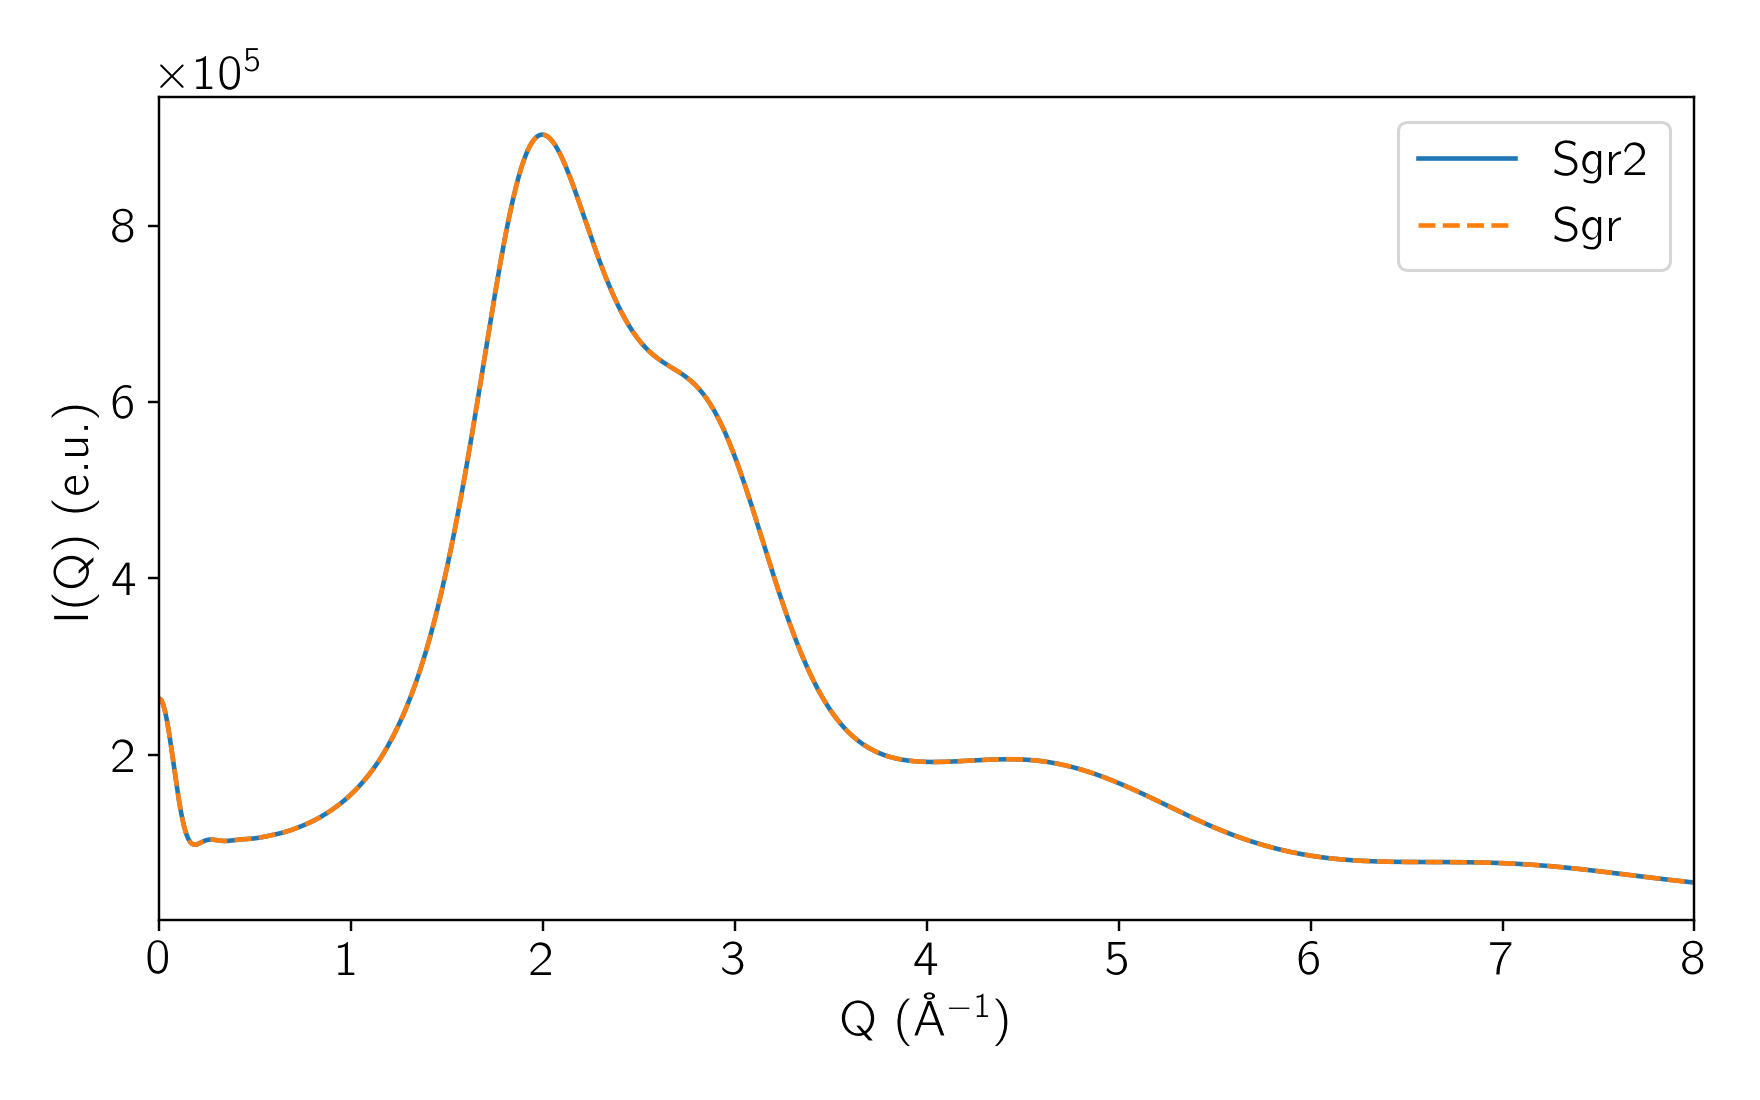

In [21]:
from cmm.xray.sgr import SGr as SGr_old
from cmm.tools.analysis import get_box_from_prmtop

import warnings  # MDAnalysis doesn't like the charge sites of tip4p in the prmtop.
warnings.filterwarnings("ignore")


rdf_files = sorted(glob.glob('../../data/md/water/waterbox_16384_amber/*dat'))
# Load universe to get stoichometry.
u = mda.Universe('../../data/md/water/waterbox_16384_amber.prmtop') 

# Unfortunately mda cannot get the box size from the prmtop, even though it is there
box = get_box_from_prmtop('../../data/md/water/waterbox_16384_amber.prmtop')

V = np.prod(box)
where1 = where2 = 'solvent'  # neat solvent RDFs. 


### Create the RDFSet 
rdfs = RDFSet()  
for f, file in enumerate(rdf_files):
    data = np.genfromtxt(file)
    r = data[:, 0]
    g = data[:, 1]
    
    # find elements from file name. This is very specific to this exact naming scheme... 
    el1 = file.split('/')[-1][1]
    el2 = file.split('/')[-1][-7]
    Ni = len([atom for atom in u.atoms if el1 in atom.name])
    Nj = len([atom for atom in u.atoms if el2 in atom.name])
    kd = int(el1 == el2)
    
    # make RDF object:
    rdf = RDF(r, g, el1, el2, where1, where2, n1=Ni, n2=Nj)
    rdf.damp = Damping('simple', L=r[-1])
    rdfs[(rdf.name1, rdf.region1, rdf.name2, rdf.region2)] = rdf
    

### Calculate Scattering
qvec = np.arange(0, 8, 0.01)
sgr = SGr2(V, qvec=qvec)    
   
s_tot_new = np.zeros(len(qvec))
for i, (key, rdf) in enumerate(rdfs.items()):
    s_tot_new += sgr.scoh(rdf)

    
## Also calculate the old way:    
stoich = {'O_v':16383, 'H_v': 16383 * 2}
sgr_old = SGr_old(V, damp=Damping('simple', L=r[-1]), 
                delta=False, verbose=False, qvec=qvec)
sgr_old.load_rdfs_fromdir('../../data/md/water/waterbox_16384_amber/')
s_tot_old = sgr_old.calculate(sgr_old.rdfs, stoich)

## Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(qvec, s_tot_new, label='Sgr2')
ax.plot(qvec, s_tot_old['s_v_damp'], '--', label='Sgr')
ax.set_xlim([0, 8])
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
fig.tight_layout()
ax.set_ylabel('I(Q) (e.u.)')
ax.set_xlabel('Q (Å$^{-1}$)')
ax.legend(loc='best');

    

Both implementations give the same water signal.